In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../')
import field_level.inference as inference
import field_level.coord as coord
import field_level.cosmo_util as cosmo_util
import field_level.power_util as power_util

import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
import jax
import jax.scipy as jsp
from jax import jit

import sys

The inference is running on cpu


### Load the mock data and measure its power spectrum

In [2]:
data_root = '/data/kakitsu/field_level/mock_data/'

boxsize = 2000.0
redshift = 0.5
true_log_Perr = 8.0

mock_signal = np.load(data_root + f'cosmo_{boxsize}_z{redshift}_s1995_gauss_512_768_128.npy')
mock_noise = np.load(data_root + f'{boxsize}_Gaussian_{true_log_Perr}_128_2006.npy')

mock_data = mock_signal + mock_noise

kbin, pk, Nk = power_util.power_compute(jnp.array(mock_data), 
                                        jnp.array(mock_data), 
                                        boxsize, nbin=20, kmin=0.0, kmax=0.2)

pk = pk.real


### Prepare the model

In [3]:
from field_level.forward_model import Forward_Model

model_name = 'gauss'

which_pk = 'cosmo'
ng = 128
ng_L = int(1.5*ng)
ng_E = 128
ng_params = [ng, ng_L, ng_E]

boxsize = 2000.0

kf = 2.*jnp.pi/boxsize
kny = jnp.pi/boxsize*ng

which_space = 'k_space' ### currently no effect

f_model = Forward_Model(model_name, which_pk, ng_params, boxsize, which_space)

model =  gauss


In [4]:
### get the linear matter power spectrum from JAX-CosmoPower

omega_b = 0.02242 ### Omega_b h^2
omega_c = 0.11933 ### Omega_cdm h^2
hubble = 0.73
ns = 0.9665
ln1010As = 3.047
OM0 = (omega_c + omega_b)/hubble/hubble

growth_f = cosmo_util.growth_f_fitting(redshift, OM0)
print('growth_f = ', growth_f)

cosmo_params = [omega_b, 
                omega_c,
                hubble,
                ns,
                ln1010As,
                0.0]   ### for the sigma8 computation

pk_lin = f_model.linear_power(cosmo_params)
sigma8 = f_model.sigma8(pk_lin)
print('sigma8 =', sigma8)
cosmo_params[-1] = redshift
pk_lin = f_model.linear_power(cosmo_params)


growth_f =  0.7175181128407132


sigma8 = 0.8350423924781688


In [46]:
kmax = 0.1
kbin_data = kbin[kbin<=kmax]
pk_data = pk[kbin<=kmax]
Nk_data = Nk[kbin<=kmax]

pk_truth = jnp.interp(kbin_data, pk_lin[0], pk_lin[1])


### Inference

In [130]:
kmax = 0.1
kbin_data = kbin[kbin<=kmax]
pk_data = pk[kbin<=kmax]
Nk_data = Nk[kbin<=kmax]

pk_truth = jnp.interp(kbin_data, pk_lin[0], pk_lin[1])

def pk_model(pk_data):
    A = numpyro.sample('A', dist.Uniform(0.5, 1.5))
    A2 = A*A
    omega_c = numpyro.sample('oc', dist.Uniform(0.05, 0.355))
    hubble = numpyro.sample('hubble', dist.Uniform(0.64, 0.82))
    H0 = numpyro.deterministic('H0', hubble*100)
    OM = numpyro.deterministic('OM', (omega_b + omega_c)/hubble/hubble)
    cosmo_params_local = jnp.array([omega_b, 
                                    omega_c,
                                    hubble,
                                    ns,
                                    ln1010As,
                                    0.0])
    pk_lin = f_model.linear_power(cosmo_params_local)
    sigma8 = numpyro.deterministic('sigma8', A * f_model.sigma8(pk_lin, type_integ='trap'))    
    cosmo_params_local = cosmo_params_local.at[-1].set(redshift)
    pk_lin = f_model.linear_power(cosmo_params_local)
    model_pk = jnp.interp(kbin_data, pk_lin[0], pk_lin[1])
    model_pk *= A2
    
    #log_Perr = numpyro.sample("log_Perr", dist.Normal(true_log_Perr, 0.5))
    log_Perr = 8.0
    Perr = jnp.exp(log_Perr)
    #sigma_err = jnp.sqrt(2.*(pk_data)**2/Nk_data)  ### directry use the measured pk in the covariance (automatically includes the measured Perr)
    sigma_err = jnp.sqrt(2.*(pk_truth + Perr)**2/Nk_data)  ### or use the emsemble averaged pk + Perr (as a parameter)
    
    Y = numpyro.sample('Y', dist.Normal(model_pk + Perr, sigma_err), obs=pk_data)


In [132]:
#params = ['A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'log_Perr']
params = ['A', 'sigma8', 'oc', 'hubble', 'H0', 'OM',]

accept_rate = 0.8

kernel = numpyro.infer.NUTS(model=pk_model,
                            target_accept_prob=accept_rate,
                            adapt_step_size=True,
                            adapt_mass_matrix=True,
                            max_tree_depth=(8, 8),
                            init_strategy=numpyro.infer.init_to_sample)


mcmc = numpyro.infer.MCMC(kernel,
                          num_samples=20000,
                          num_warmup=1000,
                          num_chains=3,
                          thinning=1,
                          chain_method="parallel",
                          progress_bar=True)



/tmp/ipykernel_10892/2625486930.py:14: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(kernel,


In [133]:
samples = {}
mcmc_seed = 2004
rng_key = jax.random.PRNGKey(mcmc_seed)
mcmc.run(rng_key, pk_data=pk_data, extra_fields=('potential_energy',))
samples['pow'] = mcmc.get_samples(group_by_chain=True)

sample: 100%|██████████| 21000/21000 [04:10<00:00, 83.68it/s, 47 steps of size 7.28e-02. acc. prob=0.95] 


/home/kakitsu/python/jax0423_env39/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'sigma8'}>,
        <Axes: title={'center': 'sigma8'}>],
       [<Axes: title={'center': 'oc'}>, <Axes: title={'center': 'oc'}>],
       [<Axes: title={'center': 'hubble'}>,
        <Axes: title={'center': 'hubble'}>],
       [<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'OM'}>, <Axes: title={'center': 'OM'}>]],
      dtype=object)

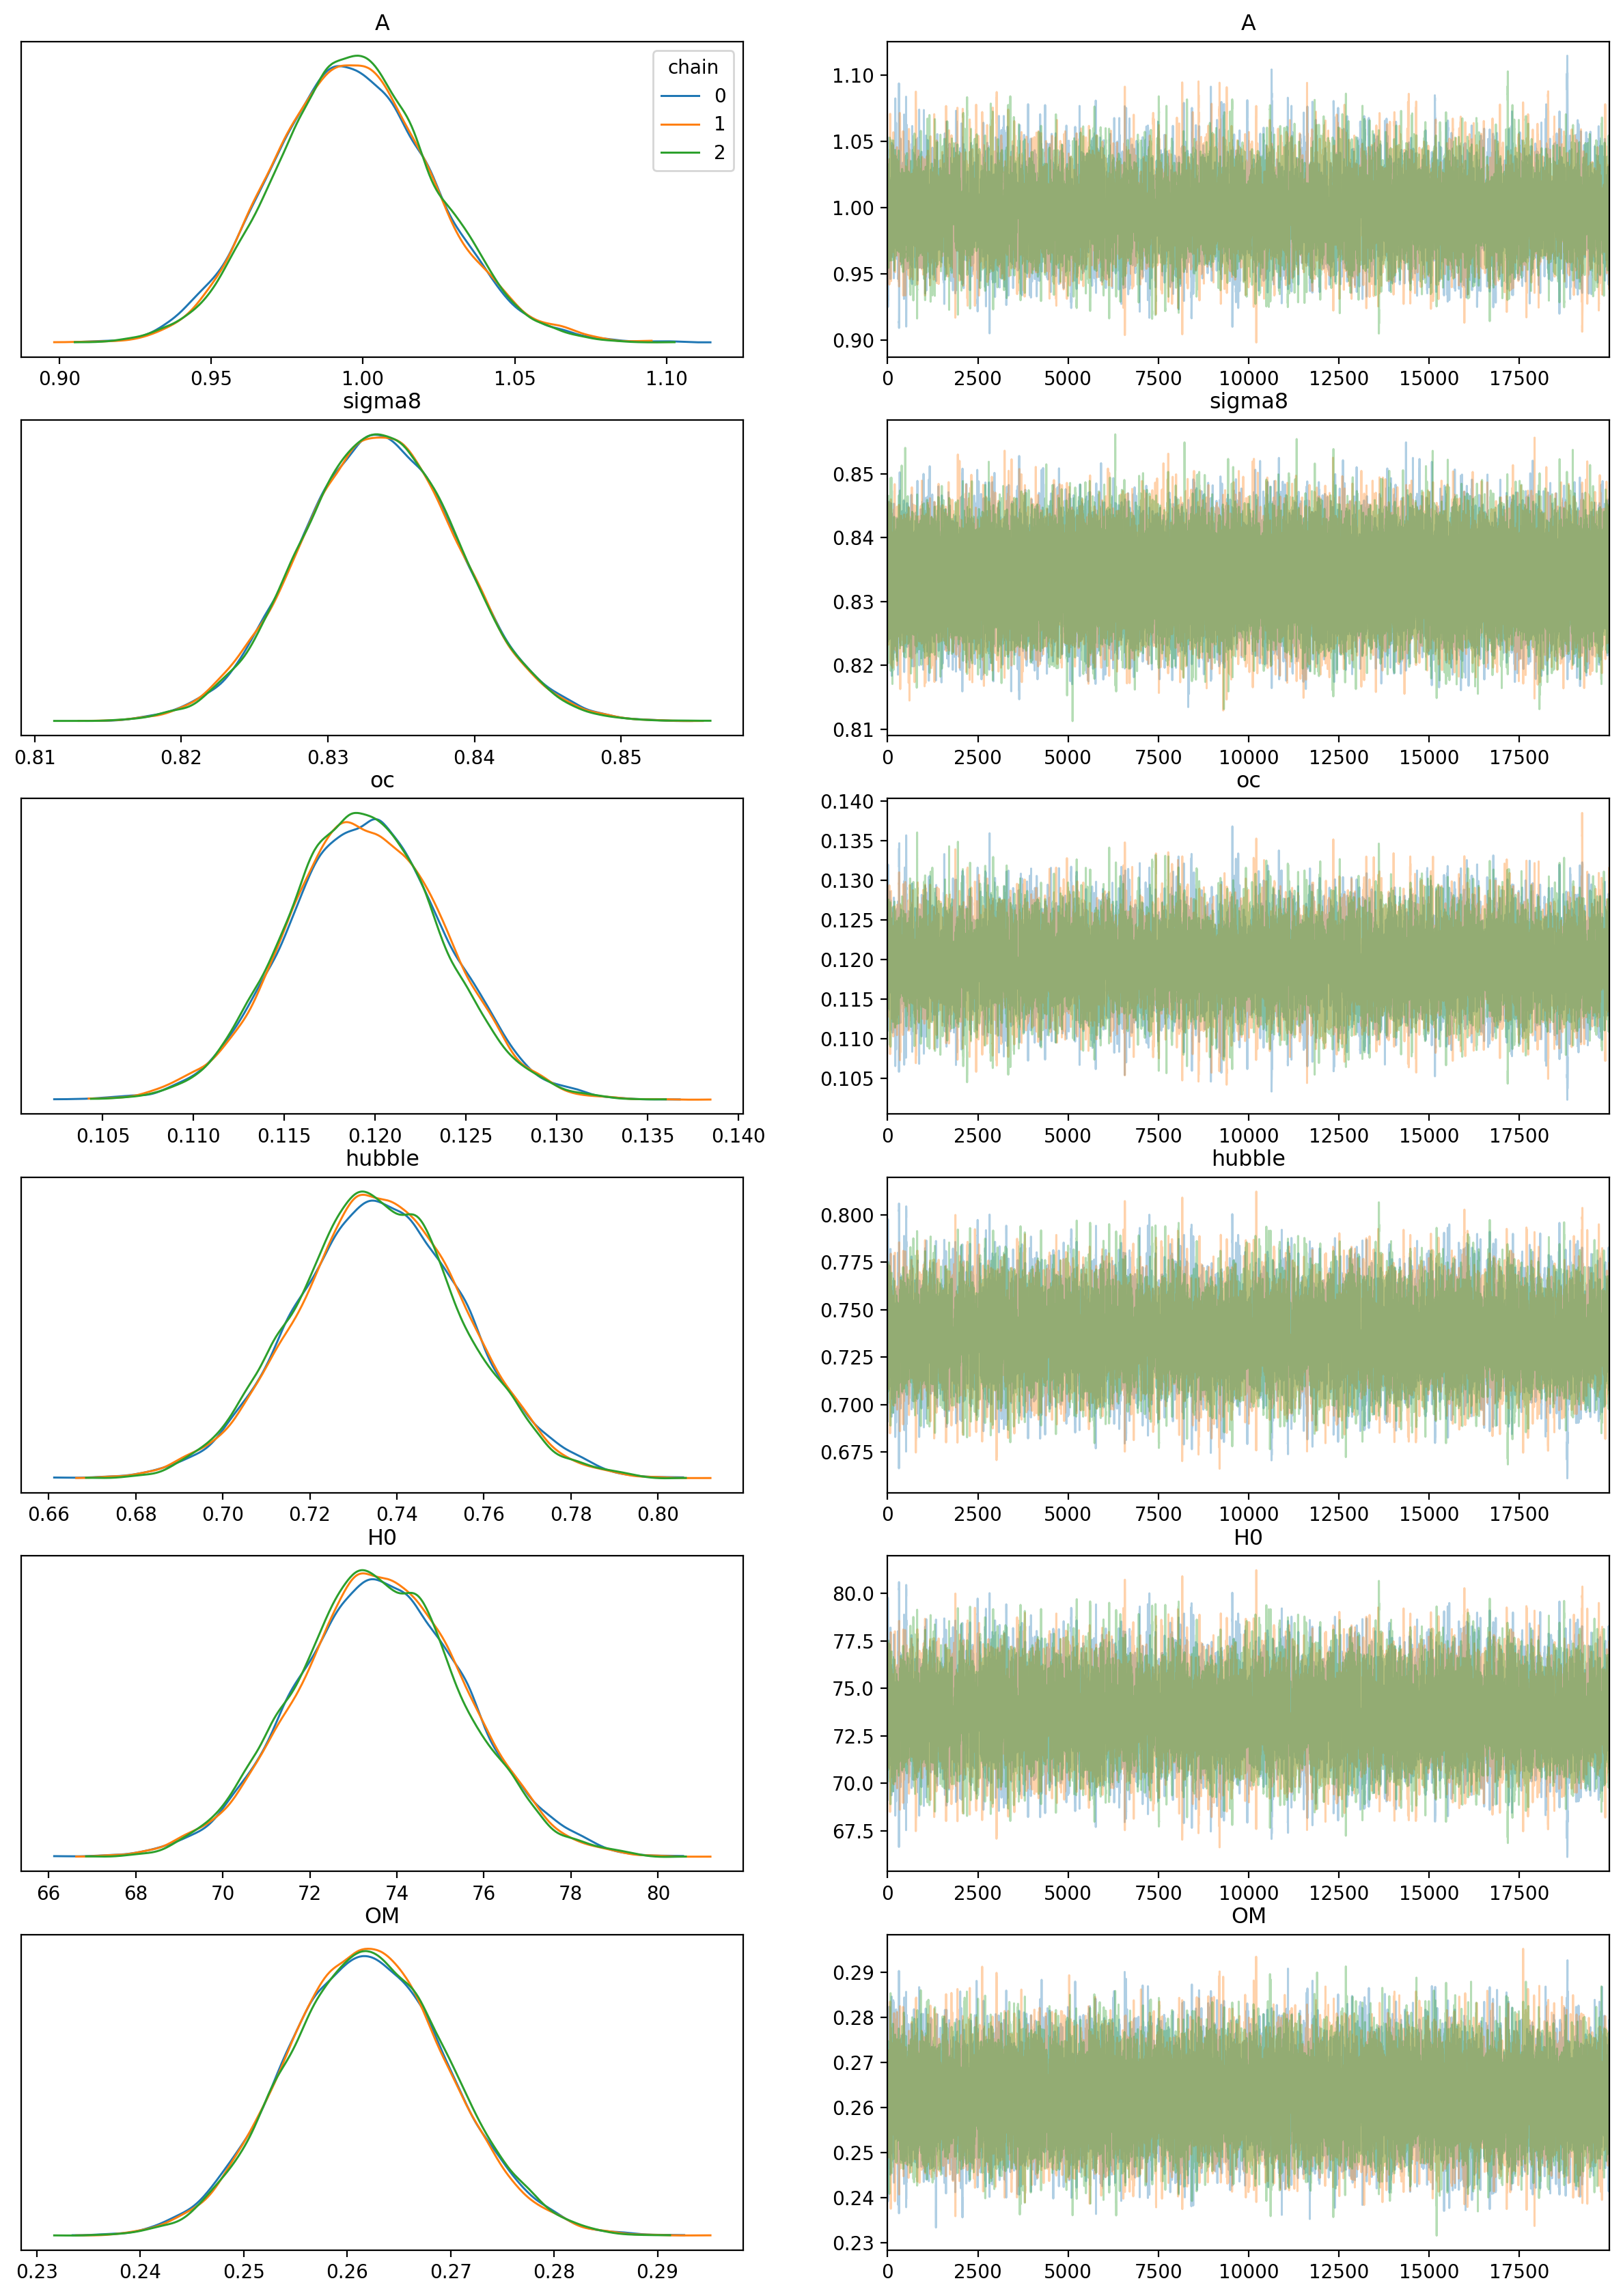

In [134]:
%matplotlib inline

import arviz as az

az.plot_trace(samples['pow'], 
              var_names=params,
              legend=True,
              compact=False,
              figsize=(15, 3.5*len(params)),
              coords={'chain':[0,1,2,]})

In [135]:

az.summary(samples['pow'],
           var_names=params,
           round_to=10,
           coords={"chain":[0,1,2]})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.997015,0.026348,0.947722,1.046404,0.000288,0.000204,8444.059492,10329.109684,1.000222
sigma8,0.833522,0.005443,0.823253,0.843747,0.000028,0.000020,38069.536357,37650.777021,1.000029
oc,0.119404,0.004300,0.111341,0.127402,0.000045,0.000032,8941.760862,10911.164891,1.000256
hubble,0.736024,0.019176,0.700408,0.772347,0.000204,0.000144,8835.171960,11018.000234,1.000236
H0,73.602433,1.917570,70.040810,77.234711,0.020386,0.014415,8835.171960,11018.000234,1.000236
OM,0.261971,0.007813,0.247105,0.276457,0.000067,0.000047,13635.649479,19058.760097,1.000245


### Load the samples of the field-level

In [136]:
root_data = '/data/kakitsu/field_level'

def name_to_label(param_name):
    if param_name == 'A':
        return 'A'
    if param_name == 'sigma8':
        return '\sigma_8'
    if param_name == 'hubble':
        return 'h'
    if param_name == 'H0':
        return 'H_0'
    if param_name == 'oc':
        return r'\omega_{\rm cdm}'
    if param_name == 'OM':
        return r'\Omega_{\rm m}'
    if param_name == 'log_Perr':
        return r'\mathrm{log}(P_{\rm err})'
    if param_name == 'b1':
        return r'b_1'
    if param_name == 'b2':
        return r'b_2'
    if param_name == 'bG2':
        return r'b_{\mathcal{G}_2}'
    if param_name == 'bGamma3':
        return r'b_{\Gamma_3}'
    if param_name == 'cs2':
        return r'c_s^2'
    if param_name == 'c1':
        return r'c_1'
    if param_name == 'growth_f':
        return r'f'
    if param_name == 'Sigma2':
        return r'\Sigma^2'
    if param_name == 'Sigma2_mu2':
        return r'\Sigma_{\mu^2}^2'

In [137]:
### common params

which_ics = 'varied_ics'
which_pk = 'cosmo'

boxsize = 2000.0
redshift = 0.5

seed = 1995

ng_data = 512
ng = 128
ng_L = int(1.5*ng)

ng_E = 128
ngs_data = [ng_data, int(1.5*ng_data), ng_E]

MAS = ''
bias_params = ''

err_type = 'Gaussian'
true_log_Perr = 8.0
seed_n = 2006
err_data_name = f'{err_type}_{true_log_Perr}_{ng_E}_{seed_n}'

accept_rate = 0.8

cosmo_params_keys = ['A', 'sigma8', 'oc', 'hubble', 'H0', 'OM']
err_params_keys = ['log_Perr']
bias_params_keys = ['b1', 'b2', 'bG2', 'bGamma3', 'cs2', 'c1']
stat_params_keys = ['potential_energy']

chains = [0,1,2]

posterior = {}

markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'log_Perr':8.0}

In [138]:
which_ics = 'varied_ics'
which_pk = 'cosmo'

boxsize = 2000.0
redshift = 0.5

seed = 1995
data_model = 'gauss'
model_name = 'gauss'

ng_data = 512
ng = 128
ng_L = int(1.5*ng)

ng_E = 128
ngs_data = f'{ng_data}_{int(1.5*ng_data)}_{ng_E}'
ngs_name = f'{ng}_{int(1.5*ng)}_{ng_E}'

MAS = ''
bias_params = ''

data_name = f'{which_pk}_{boxsize}_z{redshift}_s{seed}_{data_model}_{ngs_data}{MAS}{bias_params}'

bias_name = ''

dense_mass_names = ['A_oc_hubble_log_Perr', ]

for amp in ['A',]:
    cosmo_name = f'_{amp}_oc_hubble'
    for err_name in ['_log_Perr', '_fixed_log_Perr']:
        params = []
        params += stat_params_keys
        params += cosmo_params_keys
        if not 'fixed' in err_name:
            params += err_params_keys
            print(params)
        for dense_mass_name in dense_mass_names:
            print('err_name = ', err_name)
            if 'sigma8' in amp:
                dense_mass_name = 'sigma8' + dense_mass_name[1:]
            if 'fixed_log_Perr' in err_name:
                dense_mass_name = dense_mass_name[:-9]
                err_name = ''
            print(dense_mass_name)
            name_base = f'{data_name}_{err_data_name}_{model_name}_{ngs_name}{MAS}{cosmo_name}{bias_name}{err_name}_{dense_mass_name}_{kmax}_{accept_rate}'
            path_base = f'{root_data}/{which_ics}/{name_base}'
            print(params)
            posterior[f'{name_base}'] = {}
            for param in params:
                #print(param)
                for i_chain in chains:
                    if i_chain == 0 :
                        posterior[f'{name_base}'][param] = np.loadtxt(f'{path_base}_{param}_chain{i_chain}.dat')
                    else:
                        tmp = np.loadtxt(f'{path_base}_{param}_chain{i_chain}.dat')
                        posterior[f'{name_base}'][param] = np.vstack([posterior[f'{name_base}'][param], tmp])
            print(posterior[f'{name_base}'].keys())

['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'log_Perr']
err_name =  _log_Perr
A_oc_hubble_log_Perr
['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'log_Perr']
dict_keys(['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'log_Perr'])
err_name =  _fixed_log_Perr
A_oc_hubble
['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM']
dict_keys(['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM'])


/home/kakitsu/python/jax0423_env39/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'sigma8'}>,
        <Axes: title={'center': 'sigma8'}>],
       [<Axes: title={'center': 'oc'}>, <Axes: title={'center': 'oc'}>],
       [<Axes: title={'center': 'hubble'}>,
        <Axes: title={'center': 'hubble'}>],
       [<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'OM'}>, <Axes: title={'center': 'OM'}>]],
      dtype=object)

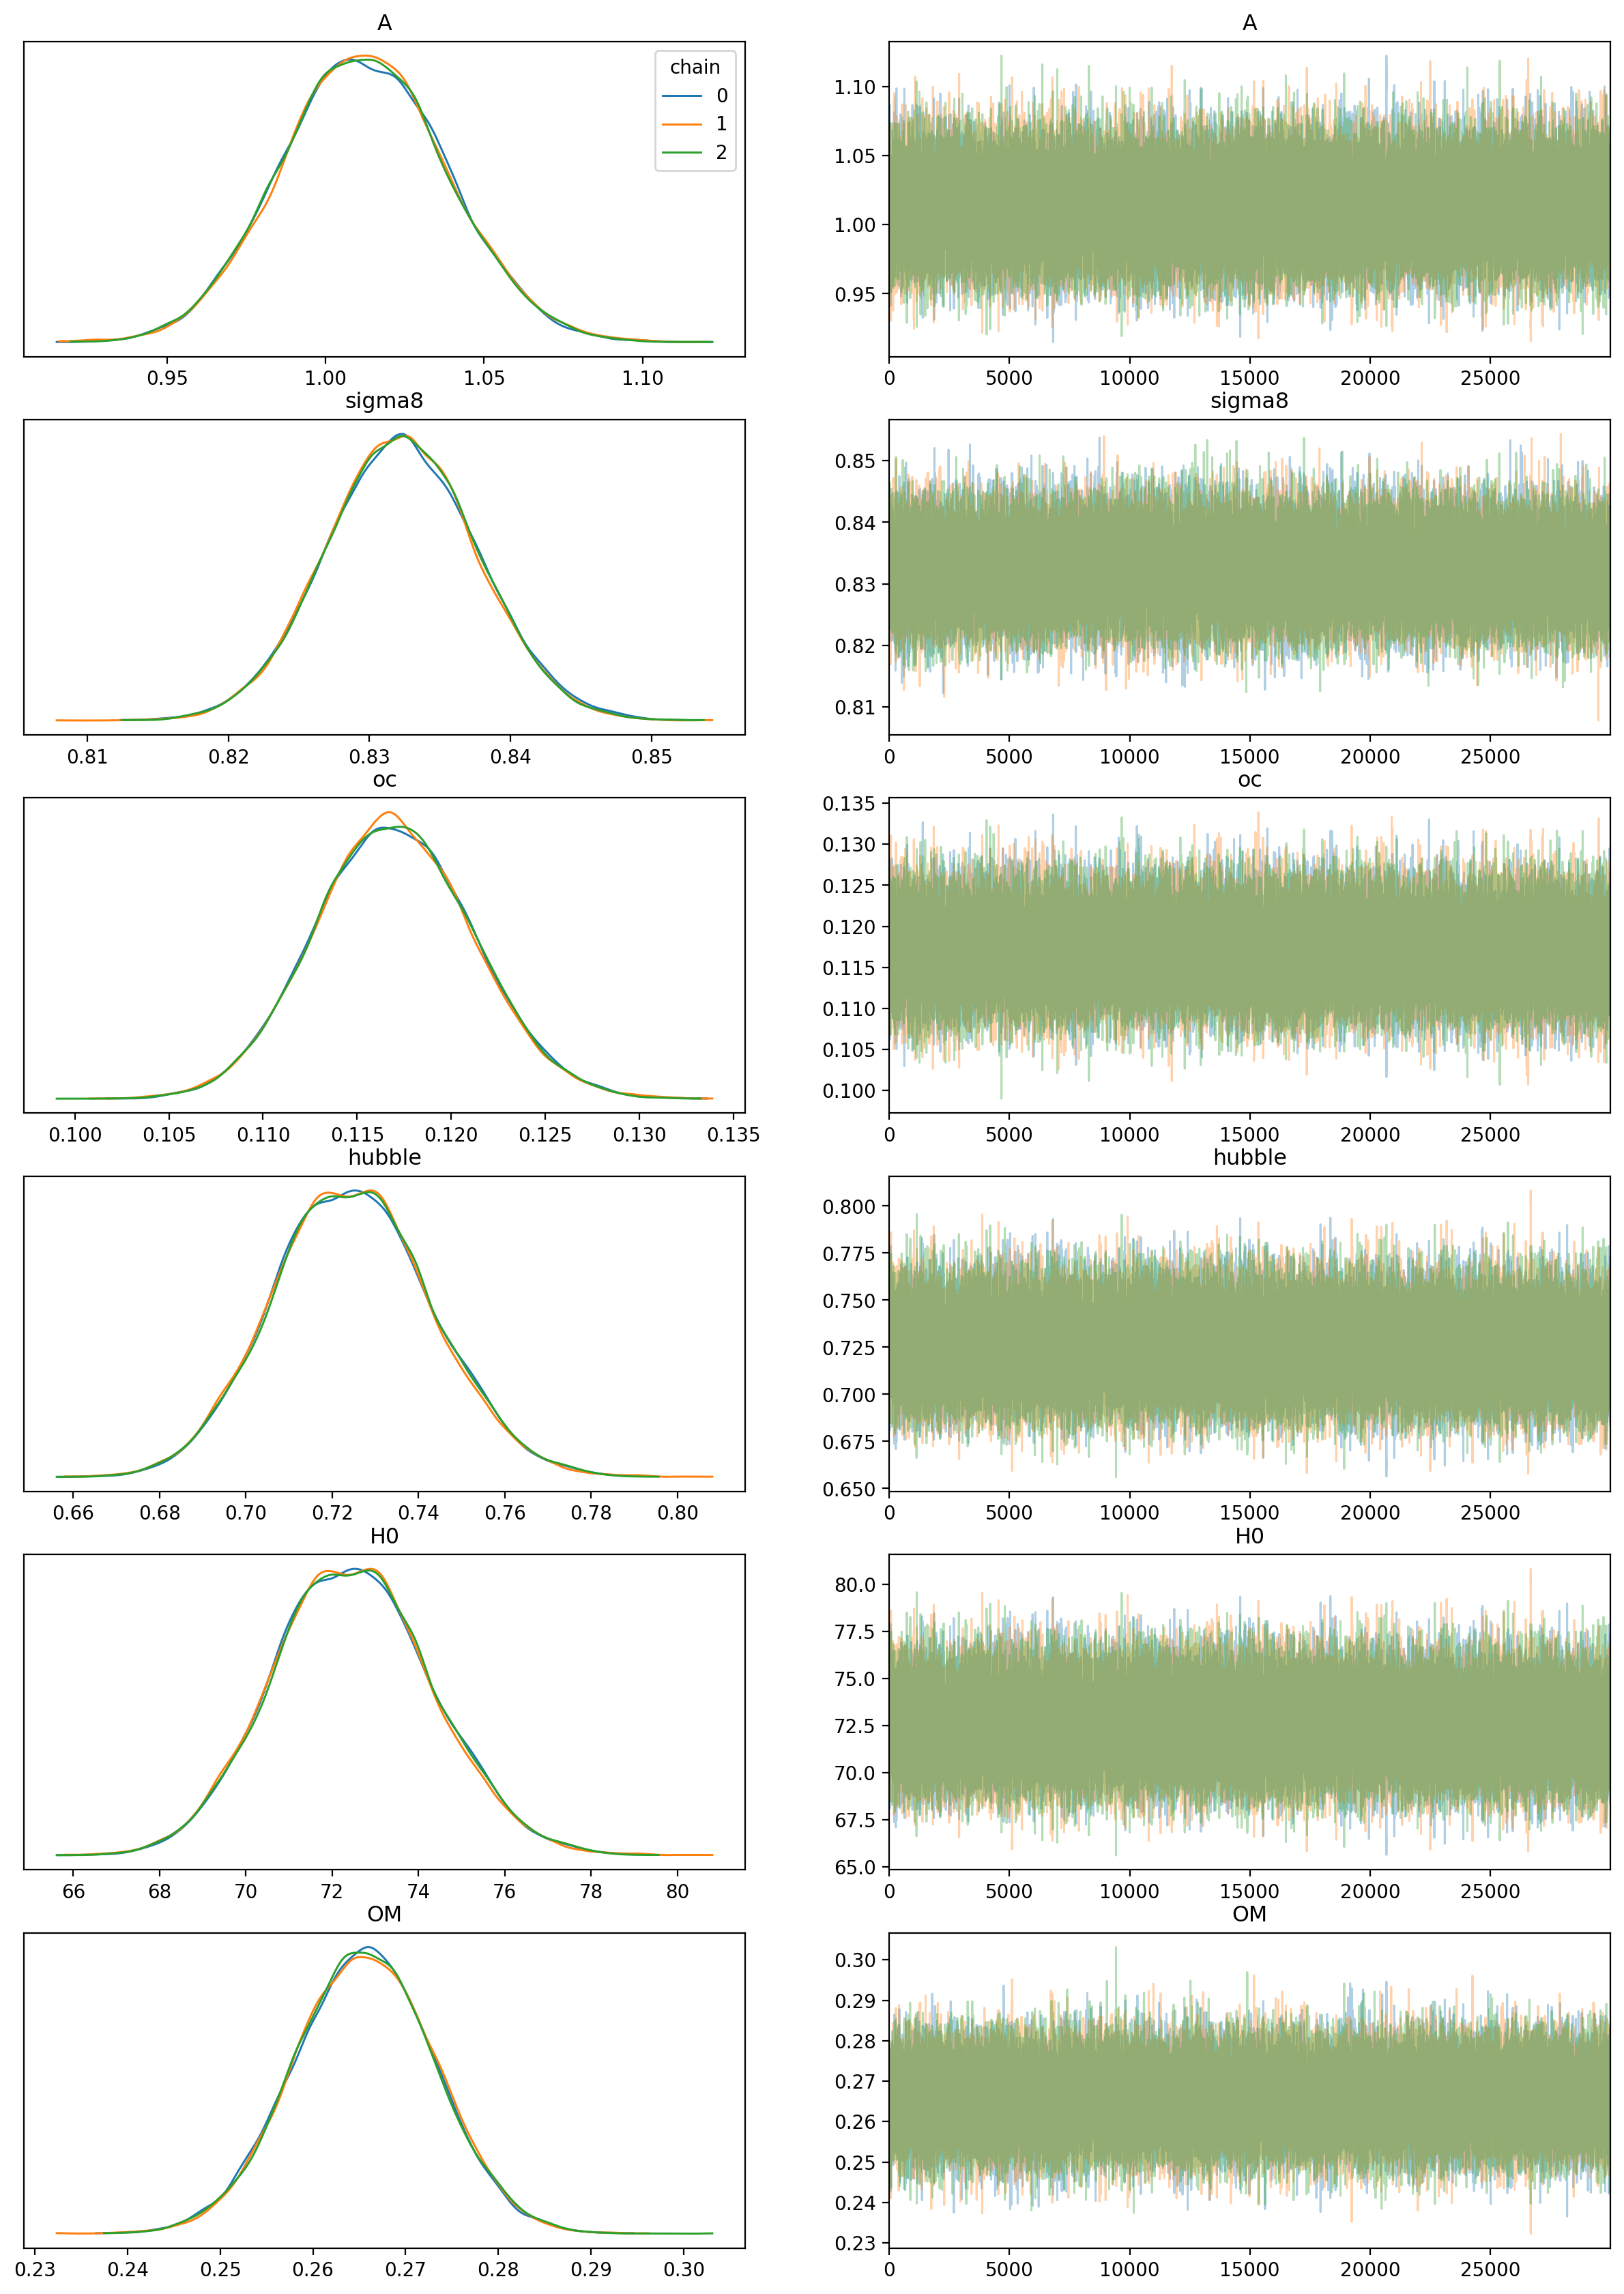

In [139]:
import arviz as az

cosmo_name = '_A_oc_hubble'
err_name = ''
#err_name = '_log_Perr'


params = []
params += cosmo_params_keys
if 'sigma8' in cosmo_name:
    dense_mass_name = 'sigma8' + dense_mass_names[0][1:]
else:
    dense_mass_name = dense_mass_names[0]
if err_name == '':
    dense_mass_name = dense_mass_name[:-9]
else:
    params += err_params_keys

name_base = f'{data_name}_{err_data_name}_{model_name}_{ngs_name}{MAS}{cosmo_name}{bias_name}{err_name}_{dense_mass_name}_{kmax}_{accept_rate}'

az.plot_trace(posterior[f'{name_base}'], 
              var_names=params,
              legend=True,
              compact=False,
              figsize=(15, 3.5*len(params)),
              coords={'chain':chains})

In [140]:
az.summary(posterior[f'{name_base}'],
           var_names=params,
           round_to=10,
           coords={"chain":[0,1,2,]})
           #coords={"chain":[1,2,]})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,1.012106,0.026302,0.962896,1.061523,0.000146,0.000103,32446.001122,51305.440056,1.000092
sigma8,0.832292,0.005357,0.822267,0.842430,0.000027,0.000019,40114.784636,60070.320937,1.000062
oc,0.116962,0.004195,0.109042,0.124794,0.000024,0.000017,31838.476802,50678.967060,1.000090
hubble,0.724754,0.018471,0.690369,0.759517,0.000101,0.000072,33500.742817,49804.867159,1.000078
H0,72.475424,1.847063,69.036911,75.951744,0.010107,0.007154,33500.741630,49804.867159,1.000078
OM,0.265515,0.007613,0.251224,0.279760,0.000040,0.000028,36402.427771,51777.164753,1.000043


In [141]:
from getdist import plots, MCSamples
import getdist

for cosmo_name in ['_A_oc_hubble', ]:
    for err_name in ['',]:
    #for err_name in ['_log_Perr',]:
        params = []
        params += cosmo_params_keys
        if 'sigma8' in cosmo_name:
            dense_mass_name = 'sigma8' + dense_mass_names[0][1:]
        else:
            dense_mass_name = dense_mass_names[0]
        if err_name == '':
            dense_mass_name = dense_mass_name[:-9]
        else:
            params += err_params_keys
        labels = []
        for param in params:
            labels += [name_to_label(param)]
        name_base = f'{data_name}_{err_data_name}_{model_name}_{ngs_name}{MAS}{cosmo_name}{bias_name}{err_name}_{dense_mass_name}_{kmax}_{accept_rate}'
        tmp = np.array(list(posterior[f'{name_base}'].values()))
        tmp = tmp.reshape(tmp.shape[0],
                          tmp.shape[1]*tmp.shape[2])
        #print(tmp[1:,].shape)
        print(name_base)
        print(params)
        print(labels)
        samples_field = MCSamples(samples=tmp[1:,].T,
                                  names = params, 
                                  labels=labels,
                                  label = f'field level')


tmp_dict = {}
for key in params:
    tmp_dict[key] = samples['pow'][key]
samples['pow'] = tmp_dict

samps_arr = np.array(list(samples['pow'].values()))
samps_arr = samps_arr.reshape(samps_arr.shape[0],
                              samps_arr.shape[1]*samps_arr.shape[2])

samples_pow = MCSamples(samples=samps_arr.T,
                        names=params,
                        labels=labels,
                        label='power spectrum')


cosmo_2000.0_z0.5_s1995_gauss_512_768_128_Gaussian_8.0_128_2006_gauss_128_192_128_A_oc_hubble_A_oc_hubble_0.1_0.8
['A', 'sigma8', 'oc', 'hubble', 'H0', 'OM']
['A', '\\sigma_8', '\\omega_{\\rm cdm}', 'h', 'H_0', '\\Omega_{\\rm m}']
Removed no burn in
Removed no burn in


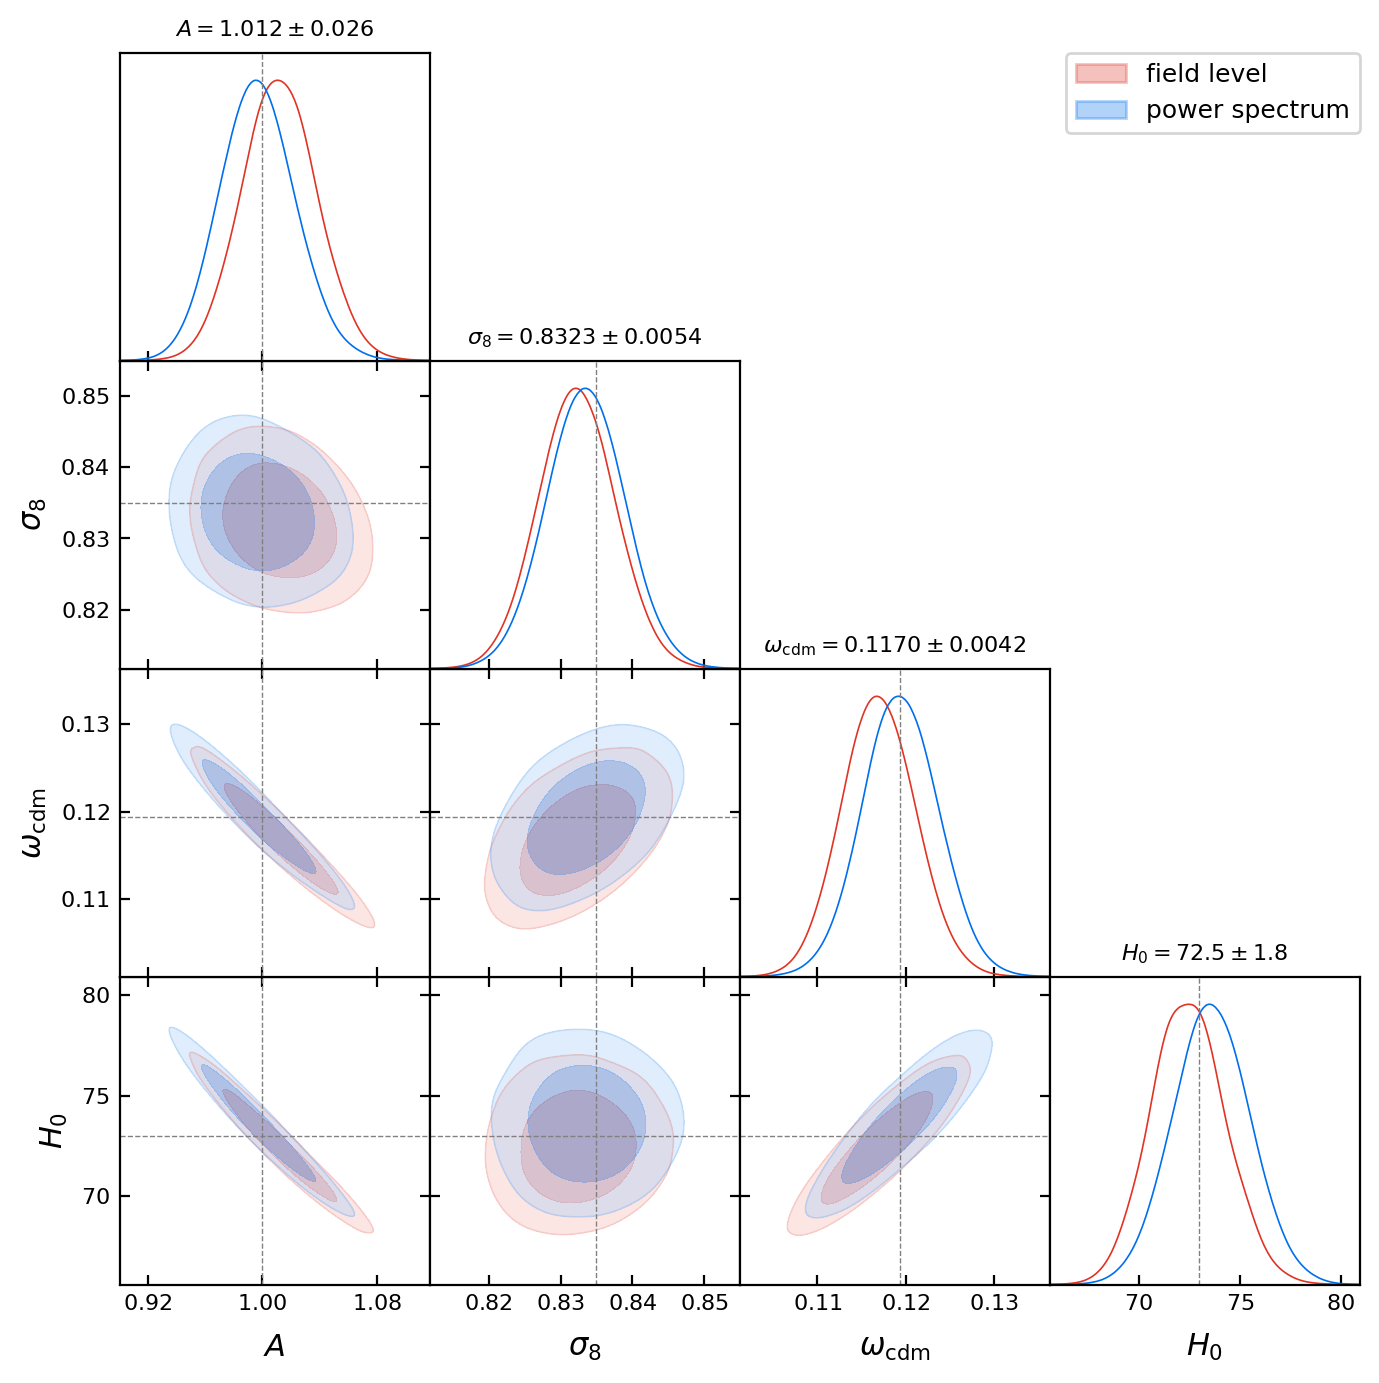

In [143]:
%matplotlib inline

g = plots.get_subplot_plotter()

params_contour = ['A', 'sigma8', 'oc', 'H0',]
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']


markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'log_Perr':8.0}
    
g.triangle_plot([samples_field,
                 samples_pow,
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')